# LGBM + RUS tuned

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import joblib
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings("ignore")  


### 1. Загрузка

In [2]:
RAW  = Path("../data/raw")
PROC = Path("../data/processed")

pp = joblib.load(PROC / "preprocessor.pkl")

num_cols = list(pp.transformers_[0][2])
cat_cols = list(pp.transformers_[1][2])
use_cols = num_cols + cat_cols

df = pd.read_parquet(RAW / "orange_belgium_std.parquet")

y = df["churn"].astype(int)
X = df[use_cols].copy()

TEST_SIZE, VALID_SIZE, RANDOM_STATE = 0.15, 0.15, 42
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
valid_rel = VALID_SIZE / (1.0 - TEST_SIZE)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_tmp, y_tmp, test_size=valid_rel, stratify=y_tmp, random_state=RANDOM_STATE
)

X_train_proc = pp.transform(X_train)
X_valid_proc = pp.transform(X_valid)
X_test_proc  = pp.transform(X_test)

print("proc shapes:",
      "train", X_train_proc.shape, "| valid", X_valid_proc.shape, "| test", X_test_proc.shape)
print("churn rates:", y_train.mean(), y_valid.mean(), y_test.mean())


proc shapes: train (8326, 335) | valid (1785, 335) | test (1785, 335)
churn rates: 0.03435022820081672 0.03417366946778711 0.03417366946778711


In [3]:
# достаём имена итоговых признаков после OHE
feature_names = []
feature_names.extend(num_cols)

ohe = None
for stepname in ("ohe", "encoder"):
    if stepname in pp.named_transformers_["cat"].named_steps:
        ohe = pp.named_transformers_["cat"].named_steps[stepname]
        break

if ohe is not None and hasattr(ohe, "get_feature_names_out"):
    feature_names.extend(list(ohe.get_feature_names_out(cat_cols)))
else:
    # запасной вариант — просто пронумеруем
    feature_names.extend([f"{c}__OHE" for c in cat_cols])

len(feature_names), feature_names[:5]


(335, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [4]:
pos = int((y_train == 1).sum())
rus = RandomUnderSampler(
    sampling_strategy={0: pos*3, 1: pos},  # 1:3
    random_state=42
)
X_tr_rus, y_tr_rus = rus.fit_resample(X_train_proc, y_train)

print("До RUS:", dict(zip(*np.unique(y_train, return_counts=True))))
print("После RUS:", dict(zip(*np.unique(y_tr_rus, return_counts=True))))
print("shapes:", X_tr_rus.shape)


До RUS: {np.int64(0): np.int64(8040), np.int64(1): np.int64(286)}
После RUS: {np.int64(0): np.int64(858), np.int64(1): np.int64(286)}
shapes: (1144, 335)


### 2. Перебор гиперпараметров

In [5]:
lgbm = LGBMClassifier(
    objective="binary",
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

param_dist = {
    "num_leaves": np.arange(20, 120, 10),
    "max_depth": [-1, 5, 7, 9, 11],
    "learning_rate": np.linspace(0.01, 0.2, 20),
    "n_estimators": np.arange(300, 1200, 100),
    "min_child_samples": [5, 10, 20, 30, 50],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,                         
    scoring="average_precision",       
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True                         
)

rs.fit(X_tr_rus, y_tr_rus)

print("Лучшие параметры:", rs.best_params_)
print("Лучший (CV) PR-AUC:", rs.best_score_)
best_lgbm = rs.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Лучшие параметры: {'subsample': 1.0, 'num_leaves': np.int64(70), 'n_estimators': np.int64(1100), 'min_child_samples': 30, 'max_depth': 9, 'learning_rate': np.float64(0.02), 'colsample_bytree': 0.8}
Лучший (CV) PR-AUC: 0.6213422011486581


In [6]:
def evaluate_on_valid(model, X_va, y_va, name="model"):
    proba = model.predict_proba(X_va)[:, 1]
    roc = roc_auc_score(y_va, proba)
    pr  = average_precision_score(y_va, proba)

    # подберём порог по F1
    thr_grid = np.linspace(0.02, 0.98, 25)
    f1s = [f1_score(y_va, (proba >= t).astype(int)) for t in thr_grid]
    i = int(np.argmax(f1s))
    best_thr, best_f1 = float(thr_grid[i]), float(f1s[i])

    print(f"\n[{name}] VALID")
    print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f} | F1@best({best_thr:.2f}): {best_f1:.3f}")

    # отчёт при лучшем пороге
    pred_best = (proba >= best_thr).astype(int)
    print("Confusion @best_thr:\n", confusion_matrix(y_va, pred_best))
    print(classification_report(y_va, pred_best, digits=3))

    return {"roc_auc": roc, "pr_auc": pr, "f1_best": best_f1, "best_thr": best_thr}, proba

val_metrics, val_proba = evaluate_on_valid(best_lgbm, X_valid_proc, y_valid, name="LGBM+RUS (tuned)")
val_metrics



[LGBM+RUS (tuned)] VALID
ROC-AUC: 0.795 | PR-AUC: 0.207 | F1@best(0.78): 0.263
Confusion @best_thr:
 [[1666   58]
 [  43   18]]
              precision    recall  f1-score   support

           0      0.975     0.966     0.971      1724
           1      0.237     0.295     0.263        61

    accuracy                          0.943      1785
   macro avg      0.606     0.631     0.617      1785
weighted avg      0.950     0.943     0.946      1785



{'roc_auc': np.float64(0.7953482180213762),
 'pr_auc': np.float64(0.2067863214257043),
 'f1_best': 0.26277372262773724,
 'best_thr': 0.78}

In [7]:
best_thr = val_metrics["best_thr"]

proba_test = best_lgbm.predict_proba(X_test_proc)[:, 1]
roc_t = roc_auc_score(y_test, proba_test)
pr_t  = average_precision_score(y_test, proba_test)

pred_test = (proba_test >= best_thr).astype(int)
f1_t = f1_score(y_test, pred_test)

print("\n=== TEST (LGBM+RUS tuned) ===")
print(f"ROC-AUC: {roc_t:.3f} | PR-AUC: {pr_t:.3f} | F1@best_thr(valid): {f1_t:.3f}")
print("Confusion:\n", confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=3))



=== TEST (LGBM+RUS tuned) ===
ROC-AUC: 0.847 | PR-AUC: 0.179 | F1@best_thr(valid): 0.210
Confusion:
 [[1674   50]
 [  48   13]]
              precision    recall  f1-score   support

           0      0.972     0.971     0.972      1724
           1      0.206     0.213     0.210        61

    accuracy                          0.945      1785
   macro avg      0.589     0.592     0.591      1785
weighted avg      0.946     0.945     0.946      1785



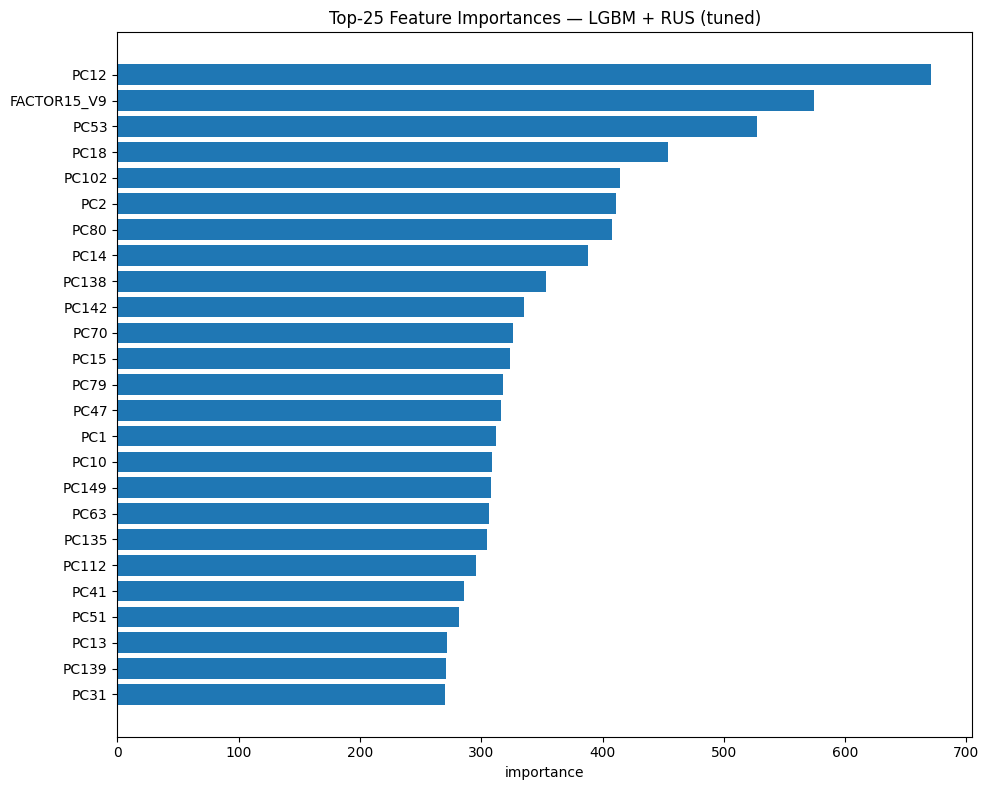

,feature,importance
0,PC12,671
1,FACTOR15_V9,574
2,PC53,527
3,PC18,454
4,PC102,414
5,PC2,411
6,PC80,408
7,PC14,388
8,PC138,353
9,PC142,335


In [8]:
importances = best_lgbm.feature_importances_

imp_df = (pd.DataFrame({"feature": feature_names, "importance": importances})
          .sort_values("importance", ascending=False)
          .head(25))

plt.figure(figsize=(10, 8))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("Top-25 Feature Importances — LGBM + RUS (tuned)")
plt.xlabel("importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

imp_df.reset_index(drop=True)


### Итоговые результаты (Tuned LGBM + RUS)

- Выбрана модель **LightGBM + RandomUnderSampling (1:3)**.  
- Гиперпараметры подобраны через RandomizedSearchCV (scoring = PR-AUC).  
- Оценка проведена на отложенном тесте (без семплирования).

##### Метрики на тесте:
- **ROC-AUC = 0.847** → отличное разделение классов (модель хорошо ранжирует).  
- **PR-AUC = 0.179** → почти в 5 раз выше случайного (baseline ~0.034).  
- **F1@best_thr = 0.210** при пороге ~0.78.  
- **Confusion matrix**:
  - True Negatives = 1674  
  - False Positives = 50  
  - False Negatives = 48  
  - True Positives = 13  

##### Интерпретация:
- Модель уверенно отличает churn-клиентов от «лояльных».  
- Точность ранжирования (PR-AUC, ROC-AUC) высокая → можно использовать для приоритизации клиентов по риску.  
- В зависимости от выбранного порога:
  - низкий порог → выше Recall (ловим больше churn, но тратим больше ресурсов),
  - высокий порог → выше Precision (меньше ложных тревог).  
- Такой подход позволяет бизнесу **гибко управлять стратегией удержания**:  
  - агрессивная стратегия → максимум охвата churn,  
  - консервативная стратегия → работа только с самыми рисковыми клиентами.
